# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy
import time
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
PATH_TO_DATA = "/media/benamira/19793564030D4273/MCsBackup/3A/MVA/DL/nlp_project/nlp_project/data"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = {item:i for i, item in enumerate(self.word2vec.keys())}
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        if type(w)==str:
            w = self.word2vec[w]
        similarities = [self.score(w, self.word2vec[self.id2word[i]]) for i in range(len(self.word2id))]
        closest_k = np.argsort(similarities)[::-1][:K]
        results = [self.id2word[i] for i in closest_k]
        return results

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        if type(w1)==str:
            e1 = self.word2vec[w1]
            e2 = self.word2vec[w2]
        else: 
            e1 = w1
            e2 = w2
        score = np.dot(e1, e2)  / (np.linalg.norm(e1)*np.linalg.norm(e2))
        return score

In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'Dog', 'doggie']
['dogs', 'dog', 'pooches', 'Dogs', 'doggies']
['paris', 'france', 'Paris', 'london', 'berlin']
['germany', 'austria', 'europe', 'german', 'berlin']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                sentemb.append(np.mean([self.w2v.word2vec[w] for w in sent if w in self.w2v.word2vec], axis=0))
            else:
                # idf-weighted mean of word vectors
                sentemb.append(np.mean([self.w2v.word2vec[w]*idf[w] for w in sent if w in self.w2v.word2vec], axis=0))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        
        scores = np.dot(keys, query.T)
        scores /= np.reshape(np.linalg.norm(keys, axis=1), (-1,1))
        closest_sentences = np.argsort(scores[:,0])
        closest_sentences = [sentences[i] for i in closest_sentences]
        print(closest_sentences[::-1][:K])

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        enc1 = self.encode([s1], idf)
        enc2 = self.encode([s2], idf)
        
        res = np.dot(enc1,enc2.T) \
            /(np.linalg.norm(enc1) * np.linalg.norm(enc2)) 
        
        return print(res[0,0])
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}        
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        
        idf = {w:max(1, np.log10(len(sentences) / v)) for (w,v) in idf.items()}
        return idf


In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=10000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
file = open(os.path.join(PATH_TO_DATA, 'sentences.txt'), "r")
sentences = [line.split() for line in file]

# Build idf scores for each word
print("Build idf")
start = time.time()
idf = s2v.build_idf(sentences)
print("Done in ", time.time()- start, "s.")

print('\n')

# You will be evaluated on the output of the following:
print("Start evaluate  BoV-mean")
start = time.time()
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13])
print("Done in ", time.time()- start, "s.")

print('\n')

print("Start evaluate  BoV-idf")
start = time.time()
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf)
print("Done in ", time.time()- start, "s.")

Loaded 10000 pretrained word vectors
Build idf
Done in  0.7116799354553223 s.


Start evaluate  BoV-mean
[['1', 'smiling', 'african', 'american', 'boy', '.'], ['girl', 'smiling', 'on', 'roller', 'coaster', '.'], ['a', 'boy', 'smiles', 'underwater', '.'], ['two', 'girlfriends', 'smiling', '.'], ['a', 'smiling', 'child', 'swims', '.']]
0.5936035444177407
Done in  6.17293906211853 s.


Start evaluate  BoV-idf
[['1', 'smiling', 'african', 'american', 'boy', '.'], ['5', 'women', 'and', '1', 'man', 'are', 'smiling', 'for', 'the', 'camera', '.'], ['2', 'guys', 'facing', 'away', 'from', 'camera', ',', '1', 'girl', 'smiling', 'at', 'camera', 'with', 'blue', 'shirt', ',', '1', 'guy', 'with', 'a', 'beverage', 'with', 'a', 'jacket', 'on', '.'], ['two', 'girlfriends', 'smiling', '.'], ['1', 'man', 'singing', 'and', '1', 'man', 'playing', 'a', 'saxophone', 'in', 'a', 'concert', '.']]
0.5004864584233165
Done in  10.949394464492798 s.


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
w2v_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)


Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
dictX = {w: w2v_fr.word2vec[w] for w in w2v_en.word2vec if w in w2v_fr.word2vec}
dictY = {w: w2v_en.word2vec[w] for w in dictX}

X = np.array([dictX[w] for w in dictX]).transpose()
Y = np.array([dictY[w] for w in dictX]).transpose()

print(X.shape)
print(Y.shape)

(300, 18970)
(300, 18970)


In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
U, S, V = np.linalg.svd(np.dot(Y, X.T), full_matrices=False)
W_fr2en = np.dot(U, V)
W_en2fr = np.linalg.inv(W_fr2en)

In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above
# TYPE CODE HERE
res_fr2en = {"words" : ['chat', 'école', 'manger', 'pendant','fier'], "results":[], "time":[] }
for w in res_fr2en["words"]:
    start = time.time()
    res_fr2en["results"].append(w2v_en.most_similar(np.dot(W_fr2en, w2v_fr.word2vec[w])))
    res_fr2en["time"].append(time.time()-start)
    
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above



# TYPE CODE HERE
res_en2fr = {"words" : ['cat', 'car', 'name', 'king','beautiful'], "results":[], "time":[] }
for w in res_en2fr["words"]:
    start = time.time()
    res_en2fr["results"].append(w2v_fr.most_similar(np.dot(W_en2fr, w2v_en.word2vec[w])))
    res_en2fr["time"].append(time.time()-start)
    

pd.set_option('max_colwidth', 800)
print('French -> English, most similar : ')
df_fr2en = pd.DataFrame(res_fr2en)
display(df_fr2en)

print('English -> French, most similar :')
df_en2fr = pd.DataFrame(res_en2fr)
display(df_en2fr)


French -> English, most similar : 


,results,time,words
0,"[cat, rabbit, hamster, feline, poodle]",0.605424,chat
1,"[école, ecole, school, supérieure, polytechnique]",0.607101,école
2,"[eat, meal, eating, eaten, ate]",0.611501,manger
3,"[during, periods, prolonged, months, intermittently]",0.594387,pendant
4,"[proud, fond, arrogant, amiable, brave]",0.597199,fier


English -> French, most similar :


,results,time,words
0,"[cat, chat, dog, chats, chien]",0.614306,cat
1,"[voiture, voitures, automobile, porsche, automobiles]",0.594589,car
2,"[nom, dénomination, noms, diminutif, surnom]",0.614192,name
3,"[roi, king, rois, reine, trône]",0.609755,king
4,"[beautiful, beauty, beauté, charmante, beautés]",0.593305,beautiful


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Ô
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
def import_sentences(path, label_bol=False):
    sentences = []
    labels = []
    start = time.time()
    print('Loading sentences...')
    file = open(os.path.join(path), "r")
    for line in file:
        sentences.append(line.split()[1:]) 
        if label_bol:
            labels.append(line.split()[0])
    labels = [int(labels[i]) for i in range(len(labels))]
    print('Loaded', len(sentences), 'sentences in ', str(time.time()-start), "s.")
    if label_bol:
        return sentences, labels
    return sentences


train_sst, train_labels = import_sentences(PATH_TO_DATA + "/SST/stsa.fine.train", label_bol=True)
val_sst, val_labels = import_sentences(PATH_TO_DATA + "/SST/stsa.fine.dev", label_bol=True)
test_sst = import_sentences(PATH_TO_DATA + "/SST/stsa.fine.test.X")


Loading sentences...
Loaded 8544 sentences in  0.08902096748352051 s.
Loading sentences...
Loaded 1101 sentences in  0.006530046463012695 s.
Loading sentences...
Loaded 2210 sentences in  0.006242513656616211 s.


In [12]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
train_embeddings = s2v.encode(train_sst)
val_embeddings = s2v.encode(val_sst)
test_embeddings = s2v.encode(test_sst)

idf = s2v.build_idf(train_sst + val_sst + test_sst)

train_embeddings_idf = s2v.encode(train_sst, idf)
val_embeddings_idf = s2v.encode(val_sst, idf)
test_embeddings_idf = s2v.encode(test_sst, idf)

scaler = preprocessing.StandardScaler().fit(train_embeddings)
train_embeddings_norm = scaler.transform(train_embeddings)
val_embeddings_norm = scaler.transform(val_embeddings)
test_embeddings_norm = scaler.transform(test_embeddings)

scaler_idf = preprocessing.StandardScaler().fit(train_embeddings_idf)
train_embeddings_norm_idf = scaler_idf.transform(train_embeddings_idf)
val_embeddings_norm_idf = scaler_idf.transform(val_embeddings_idf)
test_embeddings_norm_idf = scaler_idf.transform(test_embeddings_idf)


In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
def metrics(classifier, embeddings, labels):
    labels_pred = classifier.predict(embeddings)
    acc = accuracy_score(labels, labels_pred)
    f1 = f1_score(labels, labels_pred, average='macro')
    return acc, f1
def plot_res(all_mes, header, name):
    df = pd.DataFrame(dict(list(enumerate(all_mes))))
    df.columns = l2_values
    df_fin = df.T
    df_fin.columns = header
    display(df_fin)
    print(name)

header = np.array(["word","weigth ","word norm","weigth norm"])
acc_max = 0
f1_max =0
l2_values = [0.1, 1, 10, 20, 100]
all_acc = []
all_f1 = []
all_acc_train = []
all_f1_train = []
print("start trainning")
start = time.time()
for l2_c in l2_values:
    all_acc_col = []
    all_f1_col = []
    all_acc_col_train = []
    all_f1_col_train = []
    for idx, (train_data,val_data) in enumerate([(train_embeddings, val_embeddings),
                       (train_embeddings_idf, val_embeddings_idf),
                       (train_embeddings_norm, val_embeddings_norm),
                       (train_embeddings_norm_idf,val_embeddings_norm_idf)]):
        clf = LogisticRegression(random_state=0, solver='lbfgs', C=l2_c,penalty='l2',tol=1e-6,
                                 multi_class='multinomial').fit(train_data, train_labels)
        acc_train, f1_train = metrics(clf, train_data, train_labels)
        acc, f1 = metrics(clf, val_data, val_labels)
        all_acc_col.append(acc)
        all_f1_col.append(f1)
        all_acc_col_train.append(acc_train)
        all_f1_col_train.append(f1_train)
        if acc>=acc_max:
            if f1>=f1_max:
                best_model = clf
                best_l2_c = l2_c
                best_idx = idx
                acc_max=acc
                f1_max = f1
    all_acc_train.append(all_acc_col_train)
    all_f1_train.append(all_f1_col_train)
    all_acc.append(all_acc_col)
    all_f1.append(all_f1_col)


plot_res(all_acc_train, header, "Accuracy on train")
plot_res(all_f1_train, header, "F1-score on train")
plot_res(all_acc, header, "Accuracy on validation")
plot_res(all_f1, header, "F1-score on validation")


print("done in ",time.time() - start ,"s.")
        
print('l2 optimal:', best_l2_c)
print('config optimal optimal:', best_idx)
print('accuracy et f1-score val pour model optimal', acc_max, f1_max)

        
        

start trainning


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

,word,weigth,word norm,weigth norm
0.1,0.418422,0.444522,0.469101,0.457865
1.0,0.455875,0.456344,0.470623,0.458099
10.0,0.462430,0.457514,0.470272,0.457982
20.0,0.461728,0.459036,0.470272,0.457982
100.0,0.464419,0.457982,0.470154,0.457982


Accuracy on train


,word,weigth,word norm,weigth norm
0.1,0.310285,0.381331,0.443472,0.428945
1.0,0.406111,0.422671,0.446250,0.430234
10.0,0.432636,0.427916,0.446278,0.430002
20.0,0.434147,0.430258,0.446332,0.430002
100.0,0.435687,0.429684,0.446182,0.430002


F1-score on train


,word,weigth,word norm,weigth norm
0.1,0.390554,0.390554,0.405086,0.395095
1.0,0.397820,0.397820,0.403270,0.391462
10.0,0.405995,0.393279,0.403270,0.391462
20.0,0.401453,0.391462,0.404178,0.391462
100.0,0.404178,0.389646,0.403270,0.391462


Accuracy on validation


,word,weigth,word norm,weigth norm
0.1,0.284929,0.328306,0.377329,0.370000
1.0,0.346753,0.367808,0.375392,0.364754
10.0,0.370866,0.364964,0.375385,0.364605
20.0,0.370122,0.363950,0.376095,0.364605
100.0,0.372417,0.360801,0.375495,0.364605


F1-score on validation
done in  38.226515769958496 s.
l2 optimal: 0.1
config optimal optimal: 2
accuracy et f1-score val pour model optimal 0.405086285195277 0.37732850022868175


In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
# Save the test predictions
labels_test_pred = best_model.predict(test_embeddings_norm)
print("pred ", len(labels_test_pred) ," cases")
file = "./logreg_bov_y_test_sst.txt"
with open(file, 'w') as f:
        for label in labels_test_pred:
            f.write(str(label) + '\n')

pred  2210  cases


In [15]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

import lightgbm as lgb

lgbm = lgb.LGBMClassifier(objective='multiclass', n_estimators=2000, reg_lambda=5000)
print(train_data.shape)
lgbm.fit(train_embeddings_norm, train_labels, eval_set=[(val_embeddings_norm, val_labels)])
acc_train, f1_train = metrics(clf, train_data, train_labels)
acc, f1 = metrics(clf, val_data, val_labels)
print('accuracy et f1-score pour model optimal train', acc_train, f1_train)
print('accuracy et f1-score pour model optimal val', acc, f1)
        

prediction_test = lgbm.predict(test_embeddings_norm)
with open('./lgb_bov_y_test_sst.txt', 'w') as f1:
    for k in prediction_test:
        f1.write(str(k) + os.linesep)


(8544, 300)
[1]	valid_0's multi_logloss: 1.57174
[2]	valid_0's multi_logloss: 1.57073
[3]	valid_0's multi_logloss: 1.56974
[4]	valid_0's multi_logloss: 1.56877
[5]	valid_0's multi_logloss: 1.56782
[6]	valid_0's multi_logloss: 1.56689
[7]	valid_0's multi_logloss: 1.56602
[8]	valid_0's multi_logloss: 1.56513
[9]	valid_0's multi_logloss: 1.56426
[10]	valid_0's multi_logloss: 1.56343
[11]	valid_0's multi_logloss: 1.56258
[12]	valid_0's multi_logloss: 1.56178
[13]	valid_0's multi_logloss: 1.56089
[14]	valid_0's multi_logloss: 1.56011
[15]	valid_0's multi_logloss: 1.55924
[16]	valid_0's multi_logloss: 1.55846
[17]	valid_0's multi_logloss: 1.55763
[18]	valid_0's multi_logloss: 1.5568
[19]	valid_0's multi_logloss: 1.55603
[20]	valid_0's multi_logloss: 1.55524
[21]	valid_0's multi_logloss: 1.55459
[22]	valid_0's multi_logloss: 1.55379
[23]	valid_0's multi_logloss: 1.55303
[24]	valid_0's multi_logloss: 1.55242
[25]	valid_0's multi_logloss: 1.55171
[26]	valid_0's multi_logloss: 1.55102
[27]	valid

[214]	valid_0's multi_logloss: 1.48133
[215]	valid_0's multi_logloss: 1.48108
[216]	valid_0's multi_logloss: 1.48083
[217]	valid_0's multi_logloss: 1.48061
[218]	valid_0's multi_logloss: 1.4804
[219]	valid_0's multi_logloss: 1.48023
[220]	valid_0's multi_logloss: 1.48008
[221]	valid_0's multi_logloss: 1.47984
[222]	valid_0's multi_logloss: 1.47958
[223]	valid_0's multi_logloss: 1.47925
[224]	valid_0's multi_logloss: 1.47903
[225]	valid_0's multi_logloss: 1.47886
[226]	valid_0's multi_logloss: 1.4786
[227]	valid_0's multi_logloss: 1.47845
[228]	valid_0's multi_logloss: 1.47817
[229]	valid_0's multi_logloss: 1.478
[230]	valid_0's multi_logloss: 1.4778
[231]	valid_0's multi_logloss: 1.47763
[232]	valid_0's multi_logloss: 1.47737
[233]	valid_0's multi_logloss: 1.47715
[234]	valid_0's multi_logloss: 1.47695
[235]	valid_0's multi_logloss: 1.47675
[236]	valid_0's multi_logloss: 1.47654
[237]	valid_0's multi_logloss: 1.47634
[238]	valid_0's multi_logloss: 1.47618
[239]	valid_0's multi_logloss:

[426]	valid_0's multi_logloss: 1.44913
[427]	valid_0's multi_logloss: 1.4491
[428]	valid_0's multi_logloss: 1.44902
[429]	valid_0's multi_logloss: 1.44893
[430]	valid_0's multi_logloss: 1.44881
[431]	valid_0's multi_logloss: 1.44867
[432]	valid_0's multi_logloss: 1.44857
[433]	valid_0's multi_logloss: 1.44847
[434]	valid_0's multi_logloss: 1.44833
[435]	valid_0's multi_logloss: 1.44819
[436]	valid_0's multi_logloss: 1.44813
[437]	valid_0's multi_logloss: 1.44792
[438]	valid_0's multi_logloss: 1.44779
[439]	valid_0's multi_logloss: 1.44776
[440]	valid_0's multi_logloss: 1.4476
[441]	valid_0's multi_logloss: 1.44754
[442]	valid_0's multi_logloss: 1.44741
[443]	valid_0's multi_logloss: 1.44731
[444]	valid_0's multi_logloss: 1.44724
[445]	valid_0's multi_logloss: 1.44715
[446]	valid_0's multi_logloss: 1.44714
[447]	valid_0's multi_logloss: 1.44704
[448]	valid_0's multi_logloss: 1.44695
[449]	valid_0's multi_logloss: 1.44682
[450]	valid_0's multi_logloss: 1.44663
[451]	valid_0's multi_loglo

[637]	valid_0's multi_logloss: 1.43162
[638]	valid_0's multi_logloss: 1.43154
[639]	valid_0's multi_logloss: 1.43146
[640]	valid_0's multi_logloss: 1.43138
[641]	valid_0's multi_logloss: 1.43135
[642]	valid_0's multi_logloss: 1.43127
[643]	valid_0's multi_logloss: 1.4312
[644]	valid_0's multi_logloss: 1.43117
[645]	valid_0's multi_logloss: 1.4311
[646]	valid_0's multi_logloss: 1.43108
[647]	valid_0's multi_logloss: 1.43105
[648]	valid_0's multi_logloss: 1.43094
[649]	valid_0's multi_logloss: 1.43093
[650]	valid_0's multi_logloss: 1.43093
[651]	valid_0's multi_logloss: 1.43083
[652]	valid_0's multi_logloss: 1.43071
[653]	valid_0's multi_logloss: 1.4307
[654]	valid_0's multi_logloss: 1.43064
[655]	valid_0's multi_logloss: 1.43057
[656]	valid_0's multi_logloss: 1.43056
[657]	valid_0's multi_logloss: 1.4305
[658]	valid_0's multi_logloss: 1.43044
[659]	valid_0's multi_logloss: 1.43037
[660]	valid_0's multi_logloss: 1.43031
[661]	valid_0's multi_logloss: 1.43017
[662]	valid_0's multi_logloss

[848]	valid_0's multi_logloss: 1.41969
[849]	valid_0's multi_logloss: 1.41962
[850]	valid_0's multi_logloss: 1.41966
[851]	valid_0's multi_logloss: 1.41962
[852]	valid_0's multi_logloss: 1.41957
[853]	valid_0's multi_logloss: 1.41951
[854]	valid_0's multi_logloss: 1.41944
[855]	valid_0's multi_logloss: 1.41949
[856]	valid_0's multi_logloss: 1.41943
[857]	valid_0's multi_logloss: 1.41937
[858]	valid_0's multi_logloss: 1.41933
[859]	valid_0's multi_logloss: 1.41924
[860]	valid_0's multi_logloss: 1.41918
[861]	valid_0's multi_logloss: 1.41917
[862]	valid_0's multi_logloss: 1.41912
[863]	valid_0's multi_logloss: 1.41909
[864]	valid_0's multi_logloss: 1.41911
[865]	valid_0's multi_logloss: 1.41902
[866]	valid_0's multi_logloss: 1.41899
[867]	valid_0's multi_logloss: 1.41892
[868]	valid_0's multi_logloss: 1.41882
[869]	valid_0's multi_logloss: 1.41879
[870]	valid_0's multi_logloss: 1.41873
[871]	valid_0's multi_logloss: 1.41862
[872]	valid_0's multi_logloss: 1.41857
[873]	valid_0's multi_log

[1059]	valid_0's multi_logloss: 1.41168
[1060]	valid_0's multi_logloss: 1.4116
[1061]	valid_0's multi_logloss: 1.41161
[1062]	valid_0's multi_logloss: 1.41156
[1063]	valid_0's multi_logloss: 1.41152
[1064]	valid_0's multi_logloss: 1.41151
[1065]	valid_0's multi_logloss: 1.41143
[1066]	valid_0's multi_logloss: 1.4114
[1067]	valid_0's multi_logloss: 1.4114
[1068]	valid_0's multi_logloss: 1.41141
[1069]	valid_0's multi_logloss: 1.41136
[1070]	valid_0's multi_logloss: 1.41136
[1071]	valid_0's multi_logloss: 1.41134
[1072]	valid_0's multi_logloss: 1.41134
[1073]	valid_0's multi_logloss: 1.41135
[1074]	valid_0's multi_logloss: 1.41132
[1075]	valid_0's multi_logloss: 1.4113
[1076]	valid_0's multi_logloss: 1.41126
[1077]	valid_0's multi_logloss: 1.41119
[1078]	valid_0's multi_logloss: 1.41111
[1079]	valid_0's multi_logloss: 1.41117
[1080]	valid_0's multi_logloss: 1.41115
[1081]	valid_0's multi_logloss: 1.41111
[1082]	valid_0's multi_logloss: 1.41107
[1083]	valid_0's multi_logloss: 1.41105
[108

[1265]	valid_0's multi_logloss: 1.40722
[1266]	valid_0's multi_logloss: 1.40724
[1267]	valid_0's multi_logloss: 1.40719
[1268]	valid_0's multi_logloss: 1.40718
[1269]	valid_0's multi_logloss: 1.40719
[1270]	valid_0's multi_logloss: 1.40717
[1271]	valid_0's multi_logloss: 1.4072
[1272]	valid_0's multi_logloss: 1.40714
[1273]	valid_0's multi_logloss: 1.40718
[1274]	valid_0's multi_logloss: 1.4071
[1275]	valid_0's multi_logloss: 1.4071
[1276]	valid_0's multi_logloss: 1.40707
[1277]	valid_0's multi_logloss: 1.40707
[1278]	valid_0's multi_logloss: 1.40707
[1279]	valid_0's multi_logloss: 1.40711
[1280]	valid_0's multi_logloss: 1.40709
[1281]	valid_0's multi_logloss: 1.40707
[1282]	valid_0's multi_logloss: 1.40704
[1283]	valid_0's multi_logloss: 1.40699
[1284]	valid_0's multi_logloss: 1.407
[1285]	valid_0's multi_logloss: 1.40691
[1286]	valid_0's multi_logloss: 1.40687
[1287]	valid_0's multi_logloss: 1.40684
[1288]	valid_0's multi_logloss: 1.40687
[1289]	valid_0's multi_logloss: 1.40691
[1290

[1472]	valid_0's multi_logloss: 1.40526
[1473]	valid_0's multi_logloss: 1.4053
[1474]	valid_0's multi_logloss: 1.4053
[1475]	valid_0's multi_logloss: 1.4053
[1476]	valid_0's multi_logloss: 1.4053
[1477]	valid_0's multi_logloss: 1.4053
[1478]	valid_0's multi_logloss: 1.40532
[1479]	valid_0's multi_logloss: 1.40529
[1480]	valid_0's multi_logloss: 1.40528
[1481]	valid_0's multi_logloss: 1.40528
[1482]	valid_0's multi_logloss: 1.40527
[1483]	valid_0's multi_logloss: 1.40526
[1484]	valid_0's multi_logloss: 1.40527
[1485]	valid_0's multi_logloss: 1.40524
[1486]	valid_0's multi_logloss: 1.40529
[1487]	valid_0's multi_logloss: 1.40525
[1488]	valid_0's multi_logloss: 1.40524
[1489]	valid_0's multi_logloss: 1.40522
[1490]	valid_0's multi_logloss: 1.40521
[1491]	valid_0's multi_logloss: 1.40516
[1492]	valid_0's multi_logloss: 1.40516
[1493]	valid_0's multi_logloss: 1.40516
[1494]	valid_0's multi_logloss: 1.40516
[1495]	valid_0's multi_logloss: 1.40519
[1496]	valid_0's multi_logloss: 1.40523
[1497

[1679]	valid_0's multi_logloss: 1.40407
[1680]	valid_0's multi_logloss: 1.40408
[1681]	valid_0's multi_logloss: 1.40407
[1682]	valid_0's multi_logloss: 1.4041
[1683]	valid_0's multi_logloss: 1.40408
[1684]	valid_0's multi_logloss: 1.40408
[1685]	valid_0's multi_logloss: 1.40412
[1686]	valid_0's multi_logloss: 1.40408
[1687]	valid_0's multi_logloss: 1.40404
[1688]	valid_0's multi_logloss: 1.40404
[1689]	valid_0's multi_logloss: 1.40401
[1690]	valid_0's multi_logloss: 1.40402
[1691]	valid_0's multi_logloss: 1.40404
[1692]	valid_0's multi_logloss: 1.40406
[1693]	valid_0's multi_logloss: 1.40404
[1694]	valid_0's multi_logloss: 1.40403
[1695]	valid_0's multi_logloss: 1.40403
[1696]	valid_0's multi_logloss: 1.40397
[1697]	valid_0's multi_logloss: 1.40393
[1698]	valid_0's multi_logloss: 1.40389
[1699]	valid_0's multi_logloss: 1.40384
[1700]	valid_0's multi_logloss: 1.40382
[1701]	valid_0's multi_logloss: 1.40386
[1702]	valid_0's multi_logloss: 1.40385
[1703]	valid_0's multi_logloss: 1.40384
[

[1885]	valid_0's multi_logloss: 1.40286
[1886]	valid_0's multi_logloss: 1.40289
[1887]	valid_0's multi_logloss: 1.40288
[1888]	valid_0's multi_logloss: 1.4028
[1889]	valid_0's multi_logloss: 1.4028
[1890]	valid_0's multi_logloss: 1.40282
[1891]	valid_0's multi_logloss: 1.4028
[1892]	valid_0's multi_logloss: 1.4028
[1893]	valid_0's multi_logloss: 1.40282
[1894]	valid_0's multi_logloss: 1.40282
[1895]	valid_0's multi_logloss: 1.40283
[1896]	valid_0's multi_logloss: 1.40279
[1897]	valid_0's multi_logloss: 1.40281
[1898]	valid_0's multi_logloss: 1.40284
[1899]	valid_0's multi_logloss: 1.40281
[1900]	valid_0's multi_logloss: 1.40277
[1901]	valid_0's multi_logloss: 1.40275
[1902]	valid_0's multi_logloss: 1.40275
[1903]	valid_0's multi_logloss: 1.40273
[1904]	valid_0's multi_logloss: 1.40272
[1905]	valid_0's multi_logloss: 1.40271
[1906]	valid_0's multi_logloss: 1.40271
[1907]	valid_0's multi_logloss: 1.40271
[1908]	valid_0's multi_logloss: 1.40269
[1909]	valid_0's multi_logloss: 1.40266
[191

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [16]:
import keras
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
# 1 - Load train/dev/test sets of SST

# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

n_classes=5

words=[]
sentences_train = []
Y_train = []
file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'), "r")
for row in file:
    sentences_train.append(row[1:])
    Y_train.append(row[0])
    for w in row.split()[1:]:
        words.append(w)

sentences_valid = []
Y_valid = []
file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'), "r")
for row in file:
    sentences_valid.append(row[1:])
    Y_valid.append(row[0])
    for w in row.split()[1:]:
        words.append(w)

sentences_test = []
file = open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'), "r")
for row in file:
    sentences_test.append(row)
    for w in row.split():
        words.append(w)
        
        
Y_valid_temp = [int(l) for l in Y_valid]
Y_train_temp = [int(l) for l in Y_train]


Y_train = to_categorical(Y_train_temp, num_classes=n_classes)
Y_val = to_categorical(Y_valid_temp, num_classes=n_classes)

vocab_size = len(words)

In [18]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
X_train = [one_hot(sentence, vocab_size) for sentence in sentences_train]
X_valid = [one_hot(sentence, vocab_size) for sentence in sentences_valid]
X_test = [one_hot(sentence, vocab_size) for sentence in sentences_test]


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [19]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
max_len = 50
X_train = keras.preprocessing.sequence.pad_sequences(X_train, max_len)
X_val = keras.preprocessing.sequence.pad_sequences(X_valid, max_len)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, max_len)

## 4.2 - Design and train your model

In [20]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW
embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = len(words)  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.4, dropout_U=0.4))
model.add(Dense(n_classes, activation='sigmoid'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.4, recurrent_dropout=0.4)`
  from ipykernel import kernelapp as app


In [21]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_lstm.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          7271840   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 7,296,997
Trainable params: 7,296,997
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


/usr/local/lib/python3.6/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 29s 3ms/step - loss: 1.5767 - acc: 0.2729 - val_loss: 1.5695 - val_acc: 0.2534
Epoch 2/6
8544/8544 [==============================] - 35s 4ms/step - loss: 1.5292 - acc: 0.3173 - val_loss: 1.4684 - val_acc: 0.3542
Epoch 3/6
8544/8544 [==============================] - 31s 4ms/step - loss: 1.3234 - acc: 0.4129 - val_loss: 1.3829 - val_acc: 0.3787
Epoch 4/6
8544/8544 [==============================] - 61s 7ms/step - loss: 1.1351 - acc: 0.4712 - val_loss: 1.4328 - val_acc: 0.3787
Epoch 5/6
8544/8544 [==============================] - 42s 5ms/step - loss: 0.9838 - acc: 0.5301 - val_loss: 1.5146 - val_acc: 0.3724
Epoch 6/6
8544/8544 [==============================] - 29s 3ms/step - loss: 0.8719 - acc: 0.5765 - val_loss: 1.6364 - val_acc: 0.3606


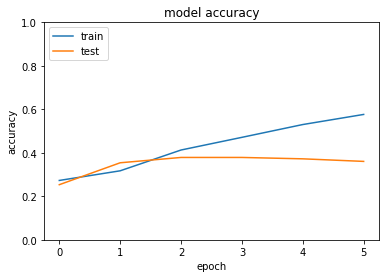

In [22]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set



# ADAPT CODE BELOW
bs = 64
n_epochs = 6



history = model.fit(X_train, Y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_val, Y_val), callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

#Model Visualisation
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
axes = plt.gca()
axes.set_ylim([0,1])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.



# TYPE CODE HERE
model.load_weights(filepath = '.mdl_lstm.hdf5')
pred_test = np.argmax(model.predict(X_test),axis=1)
with open('./logreg_lstm_y_test_sst.txt', 'w') as f1:
    for k in pred_test:
        f1.write(str(k) + os.linesep)

## 4.3 -- innovate !

Creating Model...


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 62s 7ms/step - loss: 1.5553 - acc: 0.2915 - val_loss: 1.5100 - val_acc: 0.3333
Epoch 2/6
8544/8544 [==============================] - 54s 6ms/step - loss: 1.3453 - acc: 0.4221 - val_loss: 1.3439 - val_acc: 0.3978
Epoch 3/6
8544/8544 [==============================] - 39s 5ms/step - loss: 1.0030 - acc: 0.5902 - val_loss: 1.4191 - val_acc: 0.3769
Epoch 4/6
8544/8544 [==============================] - 37s 4ms/step - loss: 0.6501 - acc: 0.7734 - val_loss: 1.6679 - val_acc: 0.3815
Epoch 5/6
8544/8544 [==============================] - 41s 5ms/step - loss: 0.3420 - acc: 0.8997 - val_loss: 2.0387 - val_acc: 0.3833
Epoch 6/6
8544/8544 [==============================] - 38s 4ms/step - loss: 0.1759 - acc: 0.9524 - val_loss: 2.3708 - val_acc: 0.3597


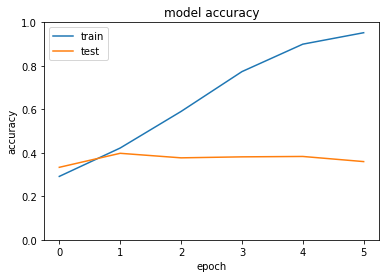

In [24]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Conv1D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
from keras.datasets import imdb
from keras.preprocessing import sequence
# Model Hyperparameters

# ADAPT CODE BELOW
bs = 64
n_epochs = 6

embedding_dim  = 32  # word embedding dimension
vocabulary_size = len(words)  # size of the vocabulary
n_classes  = 5
sequence_length = 50
num_filters = 512
filter_sizes = [3,4,5]
drop = 0.5

# this returns a tensor
print("Creating Model...")
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
model_output = Dense(5, activation="softmax")(dropout)
model = Model(inputs, model_output)


earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_proposed.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, Y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_val, Y_val), callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

#Model Visualisation
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
axes = plt.gca()
axes.set_ylim([0,1])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# TYPE CODE HERE
model.load_weights(filepath = '.mdl_proposed.hdf5')
pred_test = np.argmax(model.predict(X_test),axis=1)
with open('./proposed_y_test_sst.txt', 'w') as f1:
    for k in pred_test:
        f1.write(str(k) + os.linesep)